# CycleGAN - przykładowa implemntacja

**GAN** (generative adversarial networks) - to klasa struktur uczenia maszynowego służąca do generacji różnego typu danych. Od obrazy, przez tekst, po rzeczy bardziej abstrakcyjne. Tematem tej pracy jest stworzenie sieci, która będzie generować obrazy w stylu impresjonistycznego malarza **Claude Moneta**, z podanego na wejściu dowolnego zdjęcia.

Zestaw danych oraz wskazówki do stworzenia modelu zostały zaczerpnięte z [Kaggla](https://www.kaggle.com/competitions/gan-getting-started). Sam model od strony teoretycznej został stworzony z pomocą pracy naukowej [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593)

## Opis architektury modelu GAN

Standardowy model GAN składa się z dwóch sieci neuronowych: **Dyskryminatora** i **Generatora**

**Dyskryminator** - jego celem jest ocenić, czy podane dane należą do klasy, którą chcemy wygenerować. W naszym przypadku czy dany obraz jest dziełem Moneta

**Generator** - jego zadaniem jest wygenerować z podanego wejścia, dane które będą należeć do żądanej klasy. W naszym przypadku dla dowolnego obrazu ma wygenerować dzieło Moneta. Funkcja kosztu generatora jest zależna od dyskryminatora.

Dyskryminator i generator są trenowani jednocześnie i ze sobą rywalizują. Generator stara się oszukać dyskryminatora i podawać mu dane, które dyskryminator oceni, jako należące do celowej klasy. Dyskryminator za to doskonali swoją predykcję, żeby odróżniać prawdziwe dane od tych wygenerowanych przez generator. Funkcje kosztu obu sieci są ze sobą powiązane i jeśli jedna maleje to druga powinna rosnąć.

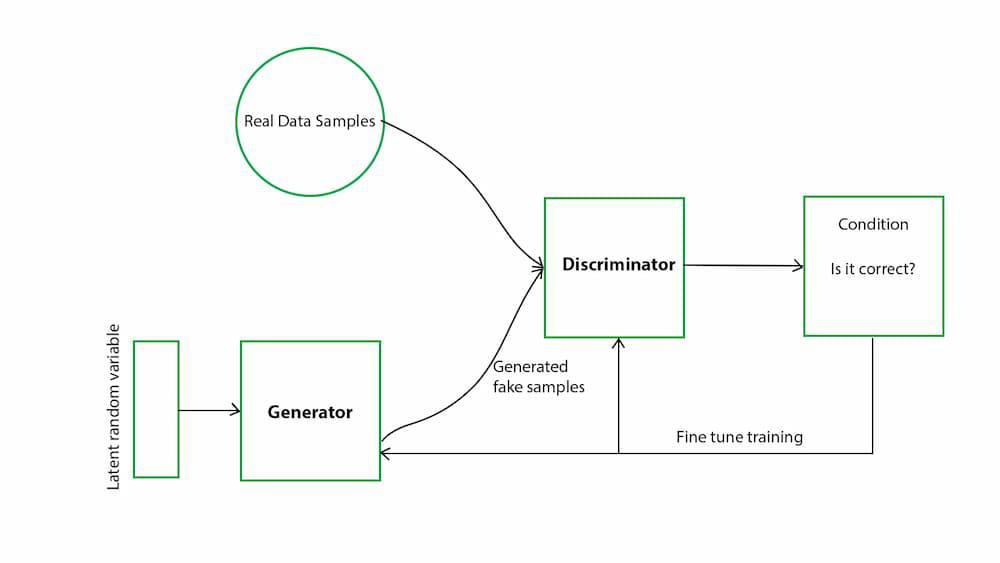

## Model collapse

Problem z jakim się mierzą sieci GAN, to zapadania się modelu (**model collapse**). Generator może zapamiętać dane wyjściowe, które spełniają warunki predykcji i zawsze, niezależnie od tego co dostanie na wejściu, zwracać te same dane. Dla naszej sieci model collapse by wystąpił, gdyby sieć zapamiętała jeden z oryginalnych obrazów Moneta i zwracała go niezależnie od wejścia. Oby tego uniknąć oprzemy nasz model o architekture CycleGAN.

## Opis architektury modelu CycleGAN

CycleGAN składa się dwóch standardowych sieci GAN - będziemy mieli więc dwa generatory i dwa dyskryminatory. 

Celem pierwszej sieci będzie przekonwertowanie oryginalnych danych, tak aby można je było zakwalifikować do klasy docelowej (tak samo jak w oryginalnym sieci GAN). 

Druga za to dostanie na wejściu dane wygenerowane przez pierwszego GAN-a i jej zadaniem będzie wrócenie do oryginalnych danych, które dostał na wejściu pierwszy GAN. 

Takie przejście przez dwie sieci będziemy nazywać **cyklem**. Oryginalne dane będziemy porównywać z ich wersją po przejściu cyklu, a wynik tego porównania będziemy wliczać do funkcji kosztu. Dzięki temu model w czasie uczenie będzie musiał wziąć pod uwagę, aby dane wyjściowe nie były za bardzo oderwane od danych wejściowych 

W naszym przypadku pierwsza sieć będzie konwertować zdjęcie na obraz Moneta. Następnie druga sieć będzie starała się znowu przekonwertować obraz wygenerowana do oryginalnego zdjęcia. Oryginalne zdjęcie a zdjęcie po przejściu cylku będziemy porównywać prostą różnicą pixeli w wartości bewzględnej 

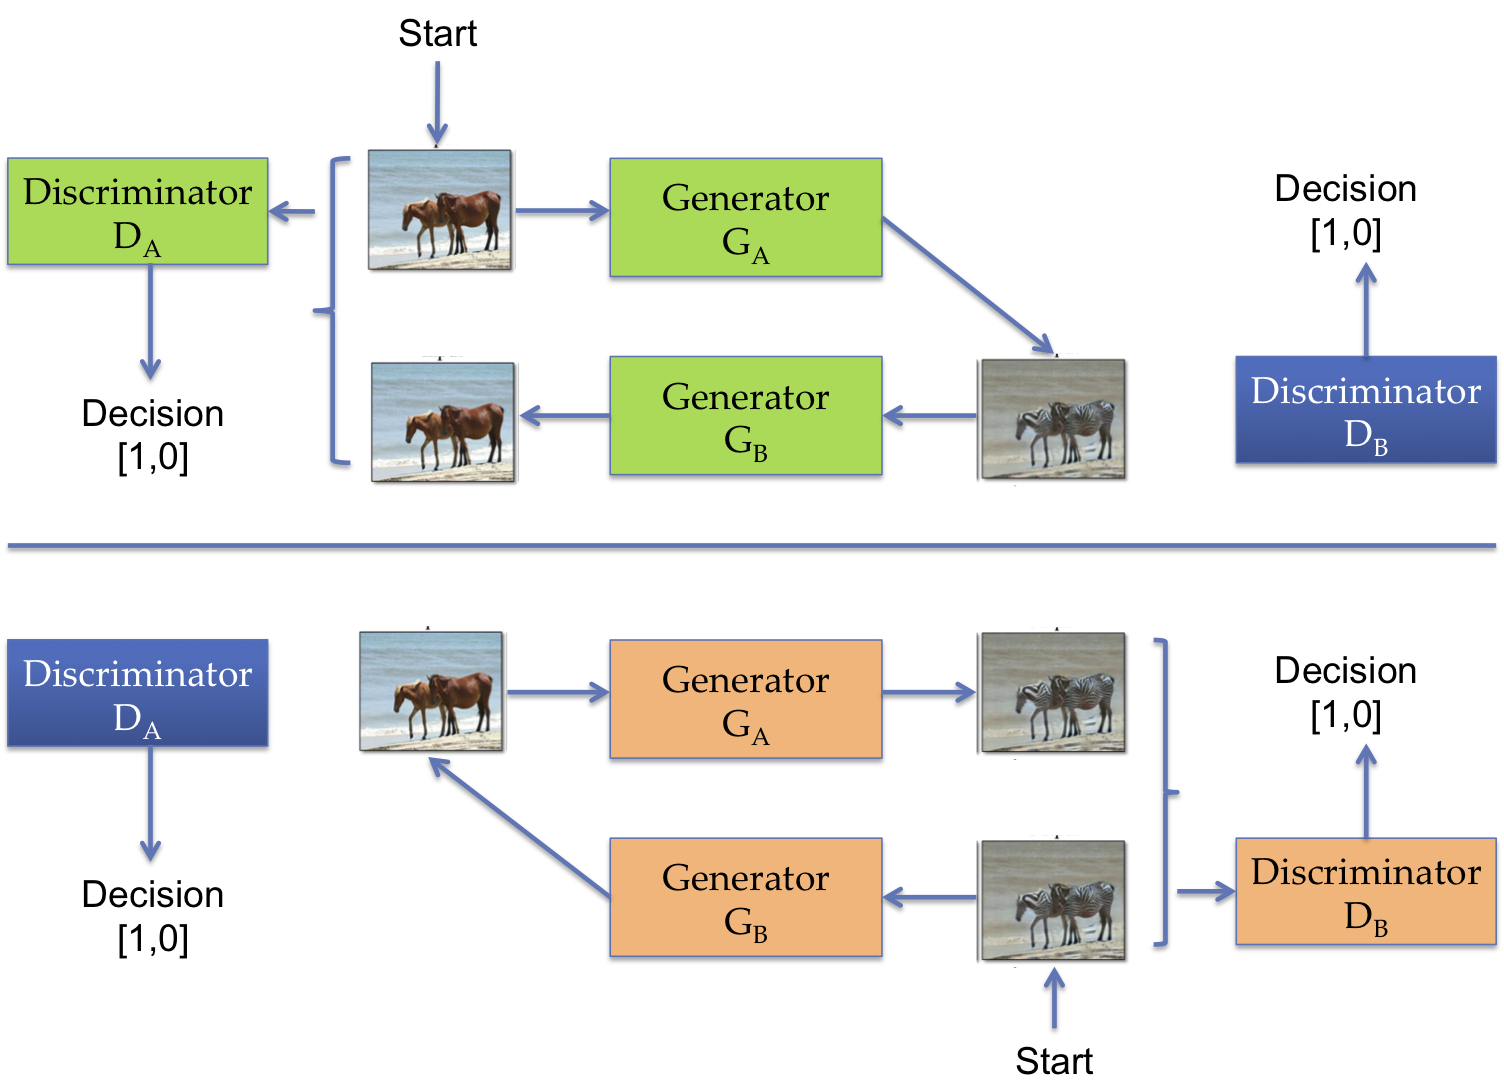

# Implementacja

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.layers import Layer
from keras.layers import InputSpec
from keras import layers

print(f"Tensorflow: {tf.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Keras: {keras.__version__}")

Tensorflow: 2.10.1
Numpy: 1.26.2
Keras: 2.10.0


In [2]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
INPUT_CHANNELS = 3
OUTPUT_CHANNELS = 3

IMAGE_SIZE = [IMAGE_HEIGHT, IMAGE_WIDTH, INPUT_CHANNELS]

### Padding

Aby utrzymać format danych wejściowych w tym samym rozmiarze po przejściu przez sieć konwolucyjną, użyjemy paddingu. Dla zdjęć padding dodaje obramowanie na kilka pixeli zwiększając rozmiar obrazu, tak aby po wykonanej kownolucji dane były w tym samym rozmiarze.

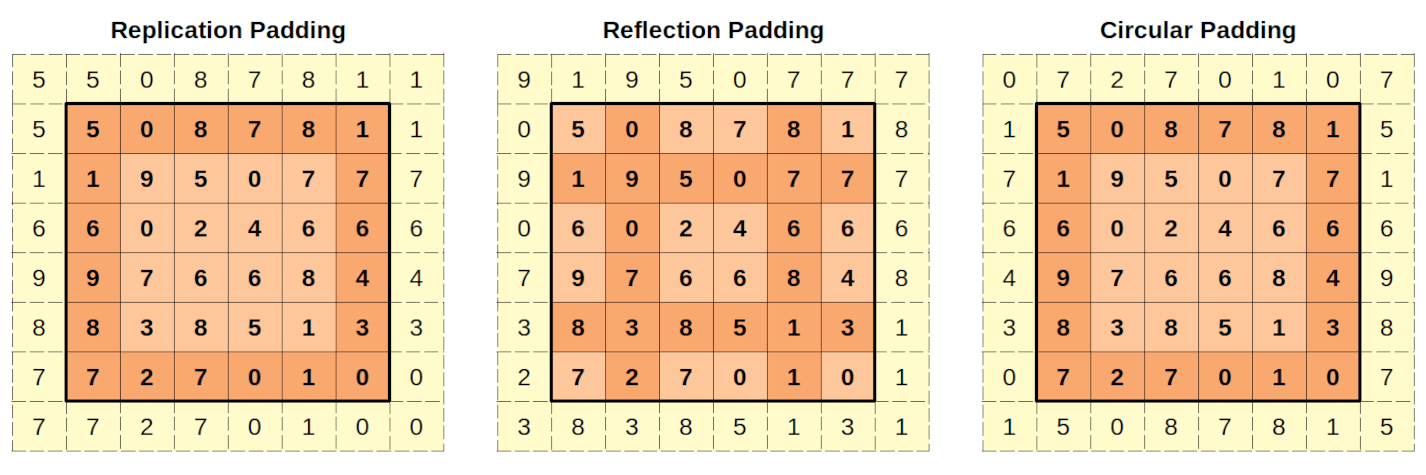

In [3]:
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def get_output_shape_for(self, s):
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

## Dyskryminator

Dyskriminator składa się z bloków, które używają sieci kownolucyjnych. Dla większości przypadków sieć będzie zmniejszać rozmiar obrazy o 2 (zmienna stride). Każdy blok będzie wykonywać:

1. Nałożenia paddingu - **ReflectionPadding**
2. Wykonania konwolucji -**Conv2D** - dla podanej liczby **filtrów** i **wielkości jądra**; zmniejszając przy tym rozmiar obrazu zależnie od zmiennej **stride**.
3. Opcjonalanie normalizacja danych - **Instance norm**
4. Opcjonalnie nałożenie funkcji aktywacji - **LeakyReLU**

In [4]:
def disrimnator_block(filters, size, stride = 2, apply_instancenorm=True, use_activation = True, idx = 0):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = keras.Sequential(name=f"disrimnator_block_{idx}")
    result.add(ReflectionPadding2D())
    result.add(layers.Conv2D(filters, size, strides=stride, kernel_initializer=initializer))

    if apply_instancenorm:
        result.add(tf.keras.layers.BatchNormalization(axis=[0, -1]))

    if use_activation:
        result.add(layers.LeakyReLU(0.2))

    return result

Dyskryminator składa się z 5 bloków, które z obrazu 256X256x3 tworzą tensor 32X32X1. Na końcowy wynik jest jeszcze nałożona sigmoida, aby utrzymać wyniki pomiędzy 0 a 1. Uznajemy dane wejściowe za obraz Moneta jeśli w naszym wektorze wejściowym wszystkie wartości dają wartość 1. Jeśli dane nie są obrazem Moneta wtedy wszystkie wartości powinny dać 0.

Zdecydowaliśmy się zastąpić jedną wartość wyjściową na wektor danych wyjściowych, aby zapobiec overfitowaniu się dyskryminatora do jednej własnoci (**Feature Matching**)

In [5]:
def Discriminator():
    inp = layers.Input(shape=IMAGE_SIZE, name='input_image', batch_size=1) # (1, 256, 256, 3)

    down1 = disrimnator_block(64, 4, apply_instancenorm=False, idx = 1)(inp) # (1, 128, 128, 64)
    down2 = disrimnator_block(128, 4, idx = 2)(down1) # (1, 64, 64, 128)
    down3 = disrimnator_block(256, 4, idx = 3)(down2) # (1, 32, 32, 256)
    down4 = disrimnator_block(512, 4, stride=1, idx = 4)(down3) # (1, 31, 31, 512)
    down5 = disrimnator_block(1, 4, stride=1, apply_instancenorm=False, use_activation=False, idx = 5)(down4) # (1, 30, 30, 1)
    last = tf.keras.layers.Activation("sigmoid")(down5)

    return tf.keras.Model(inputs=inp, outputs=last)

In [6]:
monet_discriminator = Discriminator()
photo_discriminator = Discriminator()
monet_discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(1, 256, 256, 3)]        0         
                                                                 
 disrimnator_block_1 (Sequen  (1, 128, 128, 64)        3136      
 tial)                                                           
                                                                 
 disrimnator_block_2 (Sequen  (1, 64, 64, 128)         131712    
 tial)                                                           
                                                                 
 disrimnator_block_3 (Sequen  (1, 32, 32, 256)         525568    
 tial)                                                           
                                                                 
 disrimnator_block_4 (Sequen  (1, 31, 31, 512)         2099712   
 tial)                                                       

## Generator

### ResNet

Architektura została oparta o sieć typy **ResNet** - sieć rezydualna. Sieć na początku zmniejszy wielkość obrazu sieciami konwolucyjnymi do rozmiaru 64X64. Następnie szereg bloków Resnet dokona konwersji danych, aby z powrotem za pomocą sieci kownolucyjnych można było je przywrócić do oryginalnego rozmiaru 256X256

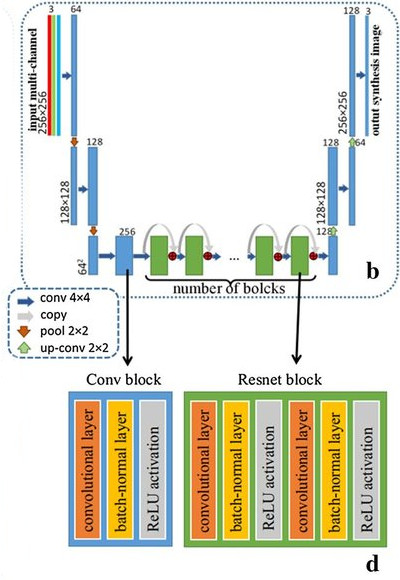

Do downsamplingu i upsamplingu użyjemy klasy generator_block. Klasa ta po kolei

1. Skaluje obraz o podaną wartość (**resisze**) - używamy dla upsamplingu
2. Nakłada padding
3. Wykonania konwolucji -**Conv2D** - dla podanej liczby **filtrów** i **wielkości jądra**; zmniejszając przy tym rozmiar obrazu zależnie od zmiennej **stride** - używamy dla downsampligu.
4. Opcjonalnie normalizacja danych - **Instance norm**
5. Opcjonalnie nałożenie funkcji aktywacji - **ReLU**

In [7]:
class Resize_layer(layers.Layer):
    def __init__(self, scale, **kwargs):
        self.__scale = scale
        super().__init__(**kwargs)

    def call(self, image: tf.Tensor):
        return tf.image.resize(image, (image.shape[1] * self.__scale, image.shape[2] * self.__scale), method="nearest")

def generator_block(filters, size, stride = 2, apply_instancenorm=True, use_activation = True, resize = 1, padding = (1, 1), idx = 0):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = keras.Sequential(name=f"generator_block_{idx}")

    if resize != 1:
        result.add(Resize_layer(resize))
    
    result.add(ReflectionPadding2D(padding=padding))
    result.add(layers.Conv2D(filters, size, strides=stride, kernel_initializer=initializer))

    if apply_instancenorm:
        result.add(tf.keras.layers.BatchNormalization(axis=[0, -1]))

    if use_activation:
        result.add(layers.ReLU())

    return result

#### ResNet Block

Aby uniknąć zaniku gradientu i przyśpieszyć uczenie się sieci, architektura ResNet składa się z ResNet Bloków. Bloki te używają **skip connection**, aby wzmocnić działanie gradientu. Matematycznie możemy określić działanie bloków jako:

$$
ResNet=F(x)+x
$$
gdzie x to dane wejściowe, a funkcje F to konwolucja wykonana w bloku

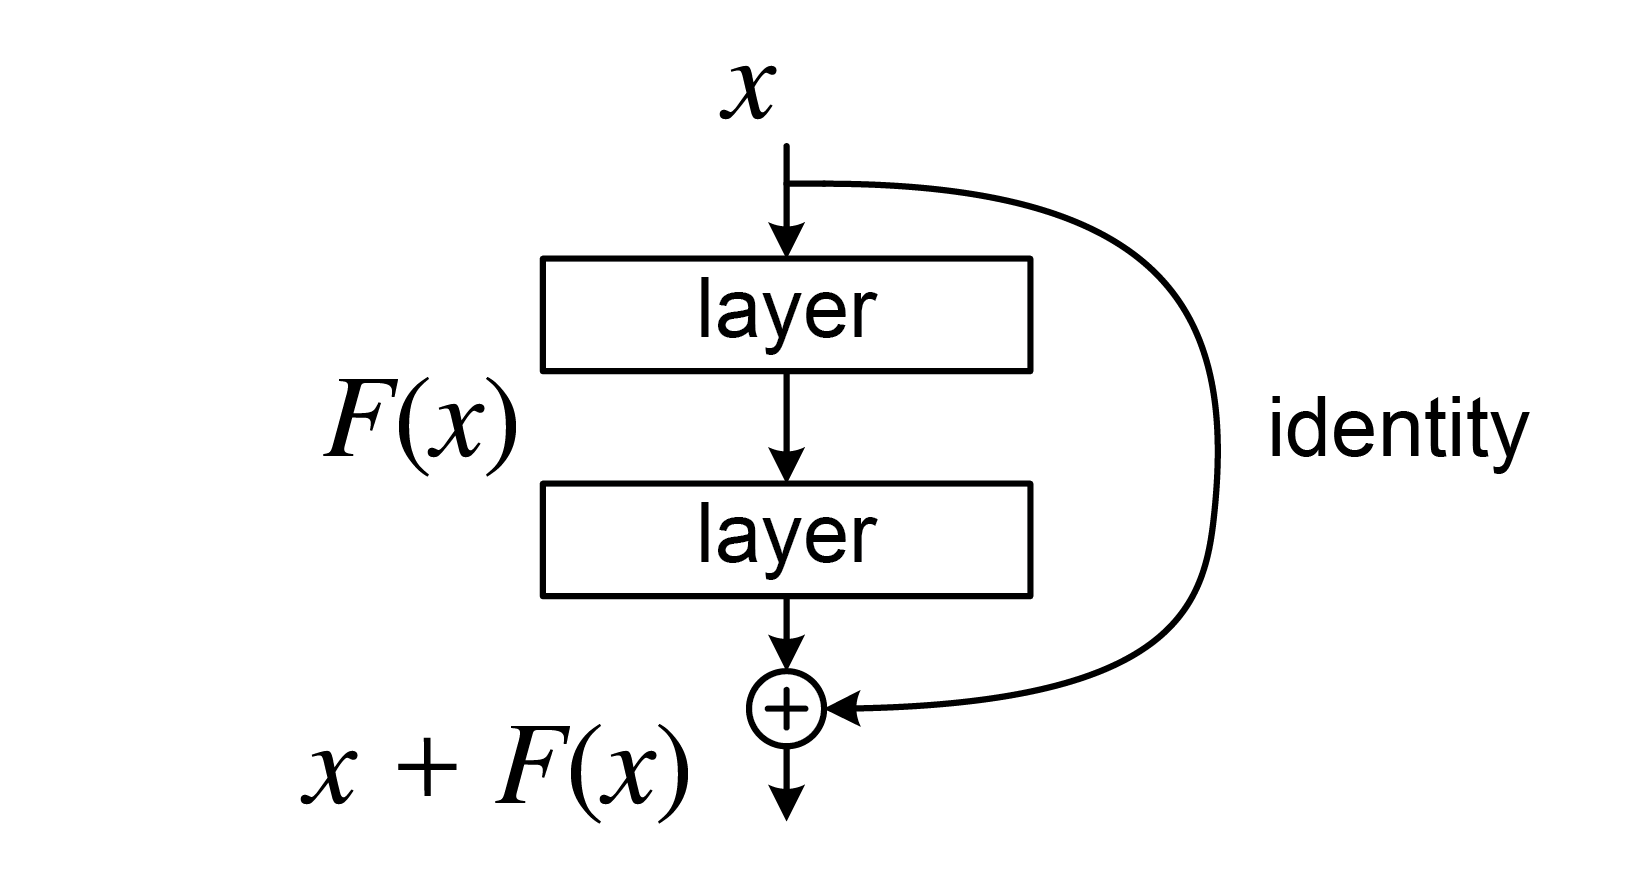

In [8]:
def resnetblock(input, filters, size, idx = 0):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = keras.Sequential(name=f"resnet_block_{idx}")

    result.add(ReflectionPadding2D())
    result.add(layers.Conv2D(filters, size, kernel_initializer=initializer))
    result.add(layers.BatchNormalization(axis=[0, -1]))
    result.add(layers.ReLU())

    result.add(ReflectionPadding2D())
    result.add(layers.Conv2D(filters, size, kernel_initializer=initializer))
    result.add(layers.BatchNormalization(axis=[0, -1]))

    result = layers.Add(name=f"resnet_add_{idx}")([result(input), input])

    return result

Nasz generator został złożony z:
- 3 bloków wykonujących downsampling
- 9 ResNet bloków
- 3 bloków wykonujących upsampling

Na końcu modelu znajduję się funkcja aktywacji - **tanh**, która zwraca wartość od -1 do 1

In [9]:
def Generator():
    input = layers.Input(shape=IMAGE_SIZE, batch_size=1) # (1, 256, 256, 3)

    result = generator_block(64, 7, stride=1, padding=(3,3), apply_instancenorm=False, idx = 1)(input) # (1, 256, 256, 64)
    result = generator_block(128, 3, idx = 2)(result) # (1, 128, 128, 128)
    result = generator_block(256, 3, idx = 3)(result) # (1, 64, 64, 256)

    result = resnetblock(result, 256, 3, idx = 1) # (1, 64, 64, 256)
    result = resnetblock(result, 256, 3, idx = 2) # (1, 64, 64, 256)
    result = resnetblock(result, 256, 3, idx = 3) # (1, 64, 64, 256)
    result = resnetblock(result, 256, 3, idx = 4) # (1, 64, 64, 256)
    result = resnetblock(result, 256, 3, idx = 5) # (1, 64, 64, 256)
    result = resnetblock(result, 256, 3, idx = 6) # (1, 64, 64, 256)
    result = resnetblock(result, 256, 3, idx = 7) # (1, 64, 64, 256)
    result = resnetblock(result, 256, 3, idx = 8) # (1, 64, 64, 256)
    result = resnetblock(result, 256, 3, idx = 9) # (1, 64, 64, 256)

    result = generator_block(128, 3, resize= 2, stride=1, idx = 4)(result) # (1, 64, 64, 128)
    result = generator_block(64, 3, resize= 2, stride=1, idx = 5)(result) # (1, 128, 128, 64)
    result = generator_block(OUTPUT_CHANNELS, 7, stride= 1, padding=(3, 3), apply_instancenorm=False, use_activation=False, idx = 6)(result) # (1, 256, 256, 3)


    last = layers.Activation("tanh")(result)


    return keras.Model(inputs=input, outputs=last)

In [10]:
monet_generator = Generator()
photo_generator = Generator()
monet_generator.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(1, 256, 256, 3)]   0           []                               
                                                                                                  
 generator_block_1 (Sequential)  (1, 256, 256, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 generator_block_2 (Sequential)  (1, 128, 128, 128)  74368       ['generator_block_1[0][0]']      
                

## Funkcje kosztu

### Dyskryminator

Funkcja za każdym razem, będzie dostawać dwa wyniki predykcji - jeden dla prawdziwego obrazu Moneta, a drugi dla wygenerowanego. Dla prawdziwego - wektor danych powinien się składać z samych 1, dla wygenerowanego - z samych 0. Suma błędów tych dwóch predykcji to funkcja kosztu.

In [11]:
def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

### Generator

Funkcja za każdym razem będzie dostawać wynik predykcji wygenerowanego przez siebie obrazu od dyskryminatora. Generator będzie chciał oszukać dyskryminatora więc przeciwnie do niego będzie oczekiwał w wektorze samych 1. Błąd jaki wyniesie będzie funkcją kosztu

In [12]:
def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

### Podobieństwo

Aby ocenić czy dane obrazy są identyczne będziemy brać średnią z wartości bezwzględnej różnicy pixeli dwóch obrazów

In [13]:
def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

In [14]:
def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

### Optymalizatory

Dla modelu został użyty standardowy optymalizator Adam

In [15]:
monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Funkcja trenująca

### Wejście

Funkcja trenująca dostaje dwa obrazy na wejście:
- **real_monet** - prawdziwy obraz moneta
- **real_photo** - prawdziwe zdjęcie

### Generowanie danych

Następnie dla każdego obrazy generatory generuje z nich trzy inne. Dla **real_photo** będzie to:
1. **fake_monet** - obraz wygenerowany przez generator_moneta dla real_photo 
2. **cycled_photo** - obraz wygenerowany przez generator_photo dla fake_monet
3. **same_photo** - obraz wygenerowany przez generator_photo dla real_photo

Analogicznie dla **real_monet**:
1. **fake_photo** - obraz wygenerowany przez generator_photo dla real_monet 
2. **cycled_monet** - obraz wygenerowany przez generator_moneta dla fake_photo
3. **same_monet** - obraz wygenerowany przez generator_moneta dla real_monet

Obraz 1 i 2 to uprzednio wspomniany **cykl**. Zdjęcie 3 jest generowane, aby generator poprawnie  działał również dla danych na wejściu już należących do klasy docelowej. Przykładowo jeśli generator moneta dostanie obraz moneta na wejście nie powinien z nim nic robić, tylko zwrócić identyczny obraz. Tą własność będziemy brać pod uwagę w funkcji kosztu generatora

### Krok gradientowy dla dyskryminatora

Każdy dyskryminator będzie oceniał dwa obrazy. 

**monet_discriminator**:
1. **fake_monet** - docelowo dyskryminator ma zwrócić tensor wypełniony 0
2. **real_monet** - docelowo dyskryminator ma zwrócić tensor wypełniony 1
   
**photo_discriminator**:
1. **fake_photo** - docelowo dyskryminator ma zwrócić tensor wypełniony 0
2. **real_photo** - docelowo dyskryminator ma zwrócić tensor wypełniony 1

Funkcja kosztu zwróci wynik dla obu dyskryminatorów. Ten wynik będzie zaaplikowany przez optimizera podczas kroku gradientowego. 

### Krok gradientowy dla generatora

Każdy generator będzie brać pod uwagę 4 zmienne podczas liczenie gradientu.

**monet_generator**:

1. Ocenę dyskryminatora dla wygenerowanego uprzednio przez niego obrazu **fake_monet**
2. Podobieństwo obrazu **real_photo** z **cycled_photo** - **cykl**
3. Podobieństwo obrazu **real_monet** z **cycled_monet** - **cykl**
4. Podobieństwo obrazu **real_monet** z **same_monet**

**photo_generator**:

1. Ocenę dyskryminatora dla wygenerowanego uprzednio przez niego obrazu **fake_photo**
2. Podobieństwo obrazu **real_photo** z **cycled_photo** - **cykl**
3. Podobieństwo obrazu **real_monet** z **cycled_monet** - **cykl**
3. Podobieństwo obrazu **real_photo** z **same_photo**

Suma tych zmiennych będzie dla nas funkcją kosztu. Ten wynik będzie zaaplikowany przez optimizera podczas kroku gradientowego. 

### Implementacja

In [16]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }
        
    def call(self, inputs):
        return (self.m_gen(inputs, training=False)[0], self.p_gen(inputs, training=False)[0])

In [17]:
cycle_gan_model = CycleGan(
    monet_generator, photo_generator, monet_discriminator, photo_discriminator
)

cycle_gan_model.compile(
    m_gen_optimizer = monet_generator_optimizer,
    p_gen_optimizer = photo_generator_optimizer,
    m_disc_optimizer = monet_discriminator_optimizer,
    p_disc_optimizer = photo_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

## Wczytanie danych

Wymiary obrazu są odpowiednio skalowane do wymiary 256X256X3. Wartości pixeli są normalizowane do wartości pomiędzy -1 a 1. Aby zwiększyć ilość danych wykonujemy horiznatlflip

In [18]:
def process(image):
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE])
    return image

def load_jpg(filenames):
    dateset =  tf.keras.utils.image_dataset_from_directory(
        filenames,
        image_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]),
        batch_size = 1,
        labels=None
    )
    dateset = dateset.map(process)
    return dateset

def augment_data(dataset): 
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
    ])
    return dataset.map(lambda x: data_augmentation(x, training = True))

def load_dataset(filenames):
    dataset = load_jpg(filenames)
    return augment_data(dataset) 

In [19]:
TARGET_PHOTO_FILENAMES = 'data/target_jpg'
INPUT_PHOTO_FILENAMES = 'data/input_jpg'

target_ds = load_dataset(TARGET_PHOTO_FILENAMES).batch(1)
input_ds = load_dataset(INPUT_PHOTO_FILENAMES).batch(1)

Found 259 files belonging to 1 classes.
Found 7038 files belonging to 1 classes.


# Trenowanie

### Callback

Aby kontrolować uczenie naszego modelu, co 25 epok funkcja trenująca będzie wywoływać callbacka, który będzie pokazywał przykładowe wyniki dla naszego modelu

In [20]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_examples=5):
        input = load_dataset(INPUT_PHOTO_FILENAMES).batch(1)
        self.photos = list(input.take(num_examples).as_numpy_iterator())

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 25 == 0:
            self.print_temporary_outcomes(epoch)

    def print_temporary_outcomes(self, epoch):
        _, ax = plt.subplots(len(self.photos), 2, figsize=(15, 15))
        for i, img in enumerate(self.photos):
            prediction = self.model(img, training=False)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).astype(np.uint8)
        
            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input Photo")
            ax[i, 1].set_title("Monet-esque")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")
        plt.suptitle(f'Epoch: {epoch}')
        plt.show()

### Trening

Found 7038 files belonging to 1 classes.
Epoch 1/200


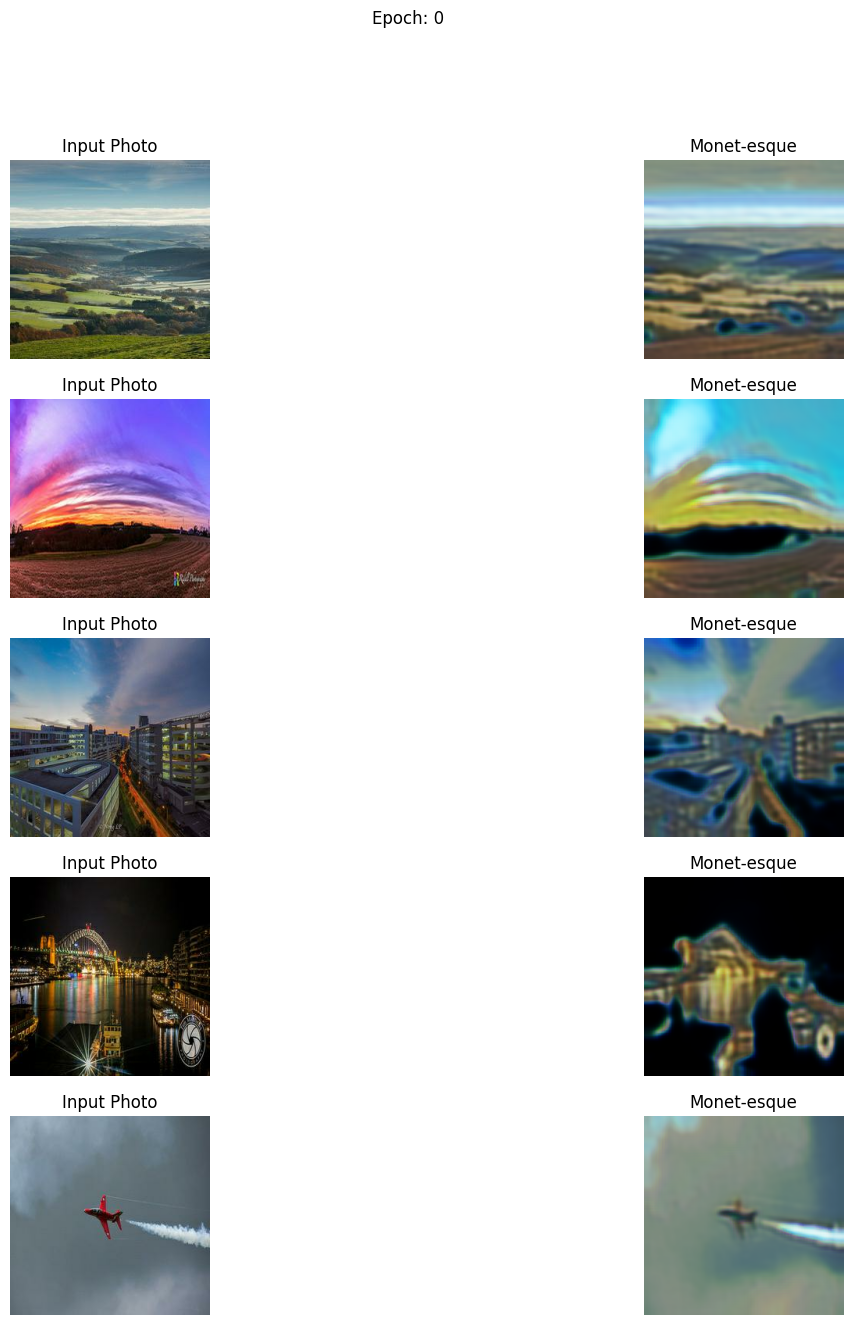

259/259 - 303s - monet_gen_loss: 6.8600 - photo_gen_loss: 6.3276 - monet_disc_loss: 0.7108 - photo_disc_loss: 0.6575 - 303s/epoch - 1s/step
Epoch 2/200
259/259 - 267s - monet_gen_loss: 6.0525 - photo_gen_loss: 5.8216 - monet_disc_loss: 0.6571 - photo_disc_loss: 0.6469 - 267s/epoch - 1s/step
Epoch 3/200
259/259 - 263s - monet_gen_loss: 6.7739 - photo_gen_loss: 5.9318 - monet_disc_loss: 0.6699 - photo_disc_loss: 0.6091 - 263s/epoch - 1s/step
Epoch 4/200
259/259 - 269s - monet_gen_loss: 5.5586 - photo_gen_loss: 5.1413 - monet_disc_loss: 0.4398 - photo_disc_loss: 0.7423 - 269s/epoch - 1s/step
Epoch 5/200
259/259 - 294s - monet_gen_loss: 7.3061 - photo_gen_loss: 6.5751 - monet_disc_loss: 0.6035 - photo_disc_loss: 0.3400 - 294s/epoch - 1s/step
Epoch 6/200
259/259 - 304s - monet_gen_loss: 5.5990 - photo_gen_loss: 6.2377 - monet_disc_loss: 0.3744 - photo_disc_loss: 0.3702 - 304s/epoch - 1s/step
Epoch 7/200
259/259 - 294s - monet_gen_loss: 6.2829 - photo_gen_loss: 6.2051 - monet_disc_loss: 0.39

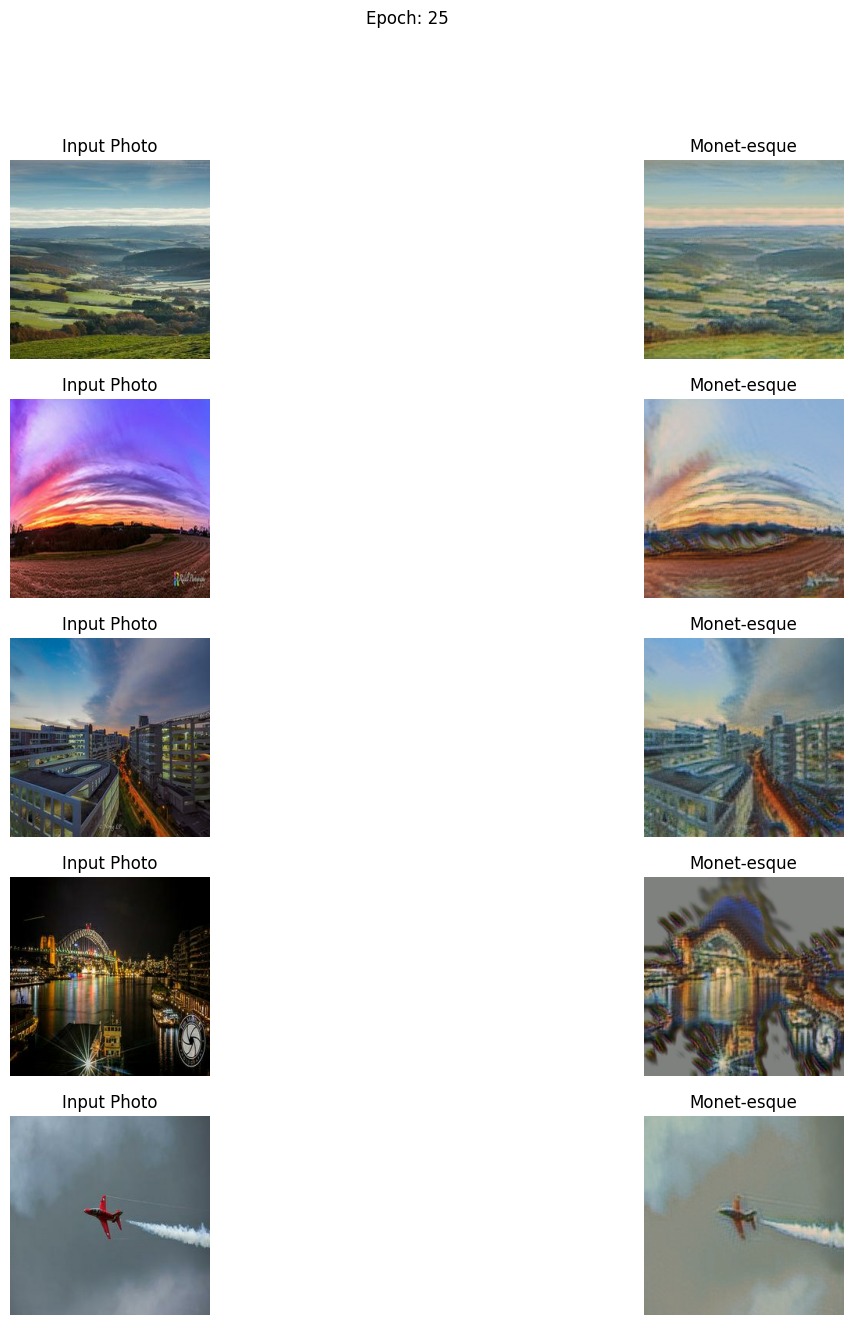

259/259 - 259s - monet_gen_loss: 6.2329 - photo_gen_loss: 5.5184 - monet_disc_loss: 0.5389 - photo_disc_loss: 0.4045 - 259s/epoch - 1s/step
Epoch 27/200
259/259 - 263s - monet_gen_loss: 4.4002 - photo_gen_loss: 5.1497 - monet_disc_loss: 0.6660 - photo_disc_loss: 0.9783 - 263s/epoch - 1s/step
Epoch 28/200
259/259 - 266s - monet_gen_loss: 5.3877 - photo_gen_loss: 5.4909 - monet_disc_loss: 0.6185 - photo_disc_loss: 0.6385 - 266s/epoch - 1s/step
Epoch 29/200
259/259 - 270s - monet_gen_loss: 6.8596 - photo_gen_loss: 6.3649 - monet_disc_loss: 0.2199 - photo_disc_loss: 0.6016 - 270s/epoch - 1s/step
Epoch 30/200
259/259 - 252s - monet_gen_loss: 6.5185 - photo_gen_loss: 5.9689 - monet_disc_loss: 0.4792 - photo_disc_loss: 0.4262 - 252s/epoch - 971ms/step
Epoch 31/200
259/259 - 252s - monet_gen_loss: 4.9774 - photo_gen_loss: 4.3659 - monet_disc_loss: 0.2516 - photo_disc_loss: 0.4366 - 252s/epoch - 974ms/step
Epoch 32/200
259/259 - 252s - monet_gen_loss: 4.5932 - photo_gen_loss: 4.8005 - monet_dis

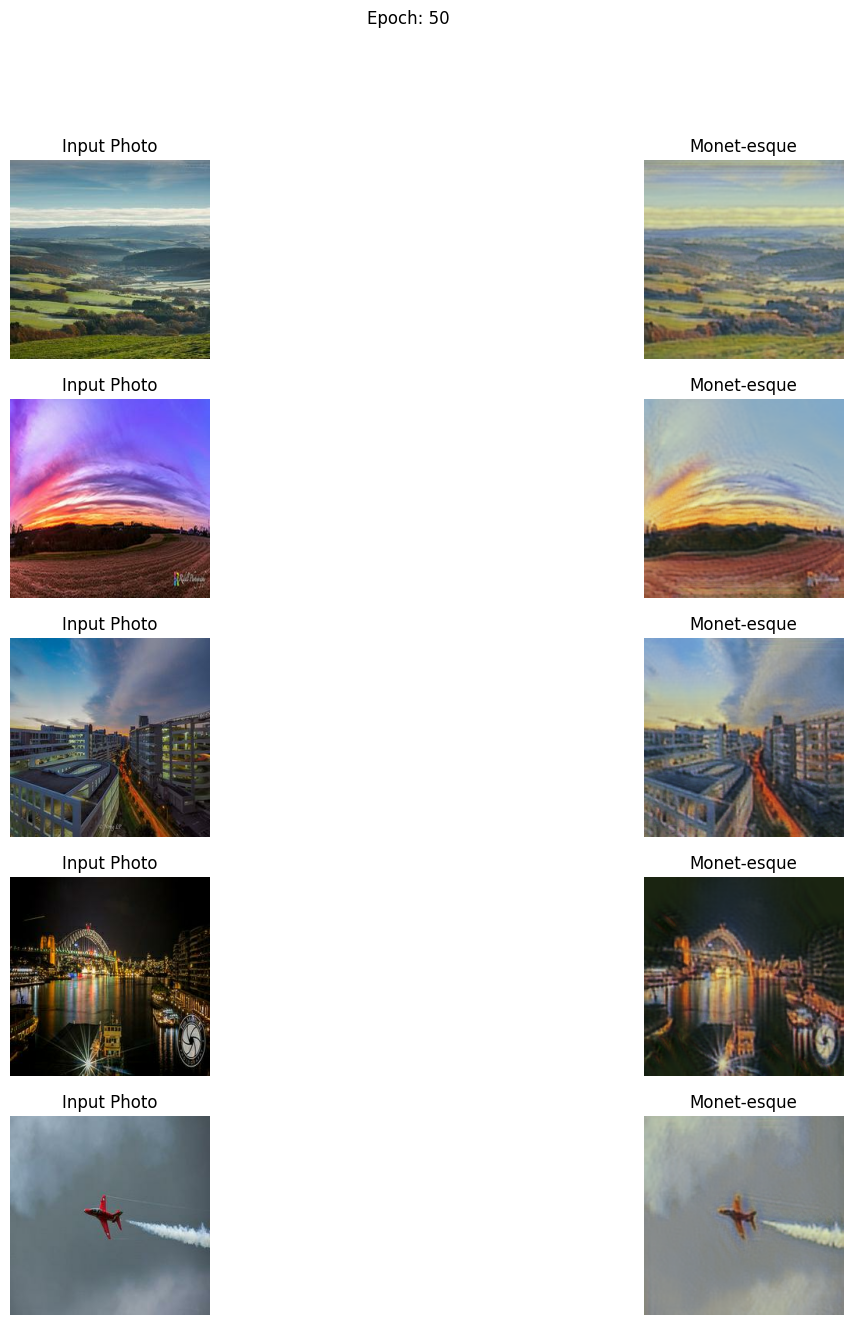

259/259 - 292s - monet_gen_loss: 6.7488 - photo_gen_loss: 5.7718 - monet_disc_loss: 0.8617 - photo_disc_loss: 0.6089 - 292s/epoch - 1s/step
Epoch 52/200
259/259 - 303s - monet_gen_loss: 4.0832 - photo_gen_loss: 5.1307 - monet_disc_loss: 0.6712 - photo_disc_loss: 0.7904 - 303s/epoch - 1s/step
Epoch 53/200
259/259 - 259s - monet_gen_loss: 4.7059 - photo_gen_loss: 4.6292 - monet_disc_loss: 0.5090 - photo_disc_loss: 0.6523 - 259s/epoch - 1s/step
Epoch 54/200
259/259 - 247s - monet_gen_loss: 5.0316 - photo_gen_loss: 4.7372 - monet_disc_loss: 0.3375 - photo_disc_loss: 0.4655 - 247s/epoch - 955ms/step
Epoch 55/200
259/259 - 246s - monet_gen_loss: 4.8559 - photo_gen_loss: 4.0856 - monet_disc_loss: 0.9359 - photo_disc_loss: 0.7146 - 246s/epoch - 950ms/step
Epoch 56/200
259/259 - 245s - monet_gen_loss: 5.3290 - photo_gen_loss: 3.8351 - monet_disc_loss: 0.3734 - photo_disc_loss: 0.6739 - 245s/epoch - 946ms/step
Epoch 57/200
259/259 - 256s - monet_gen_loss: 5.3182 - photo_gen_loss: 5.8952 - monet_

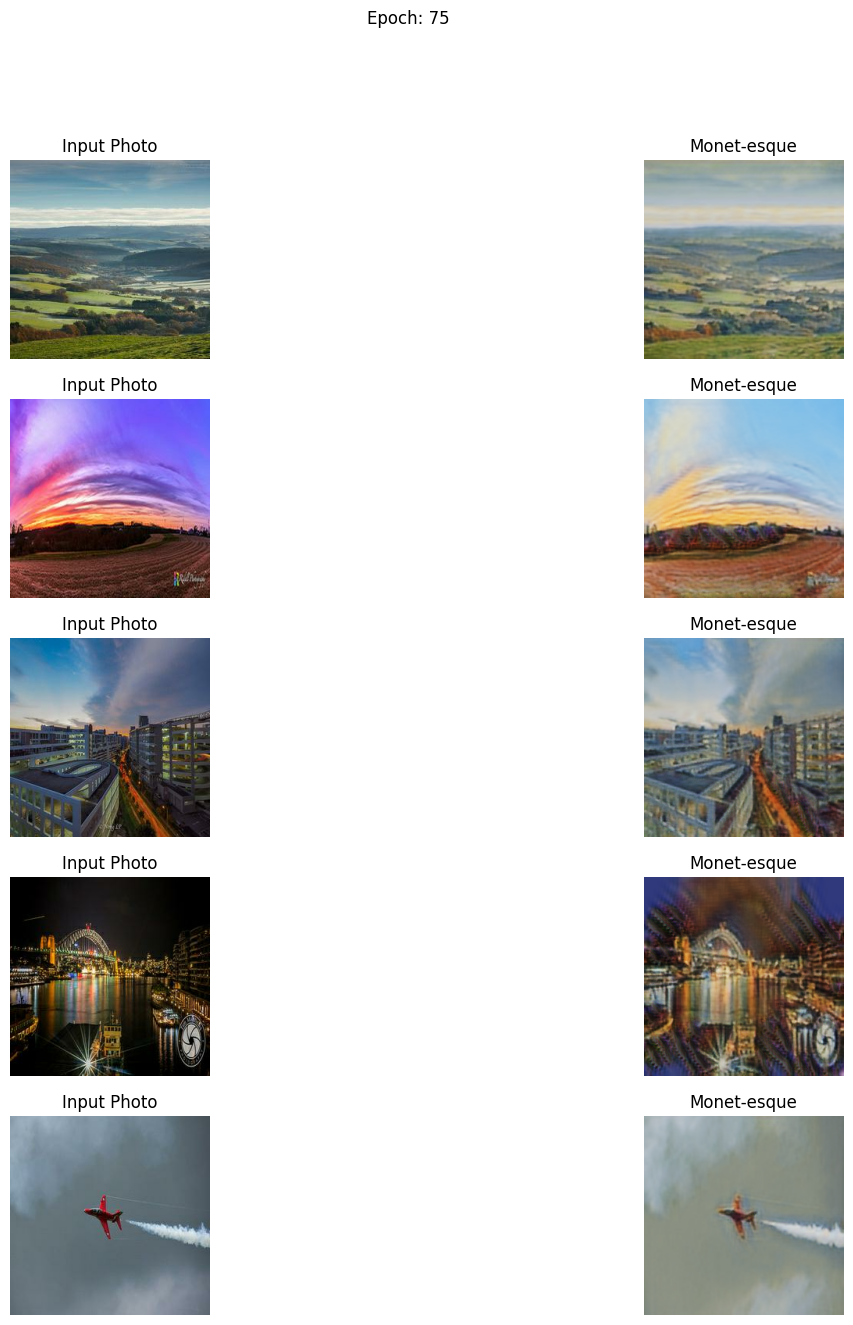

259/259 - 263s - monet_gen_loss: 4.8307 - photo_gen_loss: 5.3713 - monet_disc_loss: 0.3988 - photo_disc_loss: 1.1435 - 263s/epoch - 1s/step
Epoch 77/200
259/259 - 257s - monet_gen_loss: 4.5906 - photo_gen_loss: 4.3915 - monet_disc_loss: 0.2903 - photo_disc_loss: 0.6265 - 257s/epoch - 993ms/step
Epoch 78/200
259/259 - 260s - monet_gen_loss: 4.6716 - photo_gen_loss: 3.3799 - monet_disc_loss: 0.5435 - photo_disc_loss: 0.7655 - 260s/epoch - 1s/step
Epoch 79/200
259/259 - 258s - monet_gen_loss: 5.0715 - photo_gen_loss: 4.9084 - monet_disc_loss: 0.6299 - photo_disc_loss: 1.1023 - 258s/epoch - 995ms/step
Epoch 80/200
259/259 - 255s - monet_gen_loss: 5.8088 - photo_gen_loss: 5.1478 - monet_disc_loss: 0.3086 - photo_disc_loss: 0.7064 - 255s/epoch - 985ms/step
Epoch 81/200
259/259 - 261s - monet_gen_loss: 4.9185 - photo_gen_loss: 5.4804 - monet_disc_loss: 0.5753 - photo_disc_loss: 0.5926 - 261s/epoch - 1s/step
Epoch 82/200
259/259 - 259s - monet_gen_loss: 6.1959 - photo_gen_loss: 6.0641 - monet_

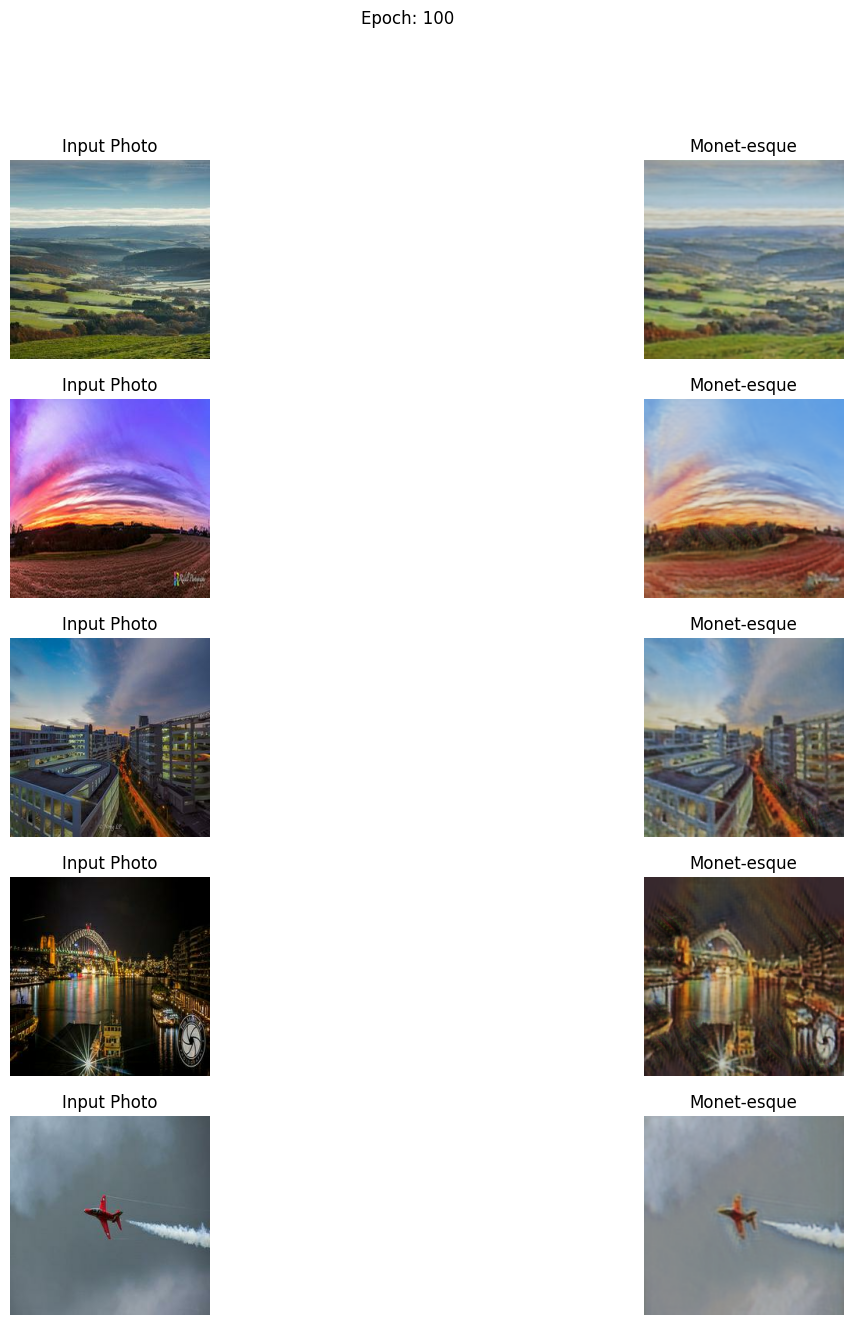

259/259 - 268s - monet_gen_loss: 6.1205 - photo_gen_loss: 5.7188 - monet_disc_loss: 0.3201 - photo_disc_loss: 0.8214 - 268s/epoch - 1s/step
Epoch 102/200
259/259 - 264s - monet_gen_loss: 4.6981 - photo_gen_loss: 4.1948 - monet_disc_loss: 0.4327 - photo_disc_loss: 0.5094 - 264s/epoch - 1s/step
Epoch 103/200
259/259 - 260s - monet_gen_loss: 4.6161 - photo_gen_loss: 3.2538 - monet_disc_loss: 0.3785 - photo_disc_loss: 0.7657 - 260s/epoch - 1s/step
Epoch 104/200
259/259 - 298s - monet_gen_loss: 5.3304 - photo_gen_loss: 6.0531 - monet_disc_loss: 0.3677 - photo_disc_loss: 0.4019 - 298s/epoch - 1s/step
Epoch 105/200
259/259 - 321s - monet_gen_loss: 5.8124 - photo_gen_loss: 5.0889 - monet_disc_loss: 0.8249 - photo_disc_loss: 0.4972 - 321s/epoch - 1s/step
Epoch 106/200
259/259 - 278s - monet_gen_loss: 5.3213 - photo_gen_loss: 4.8770 - monet_disc_loss: 0.3663 - photo_disc_loss: 1.0454 - 278s/epoch - 1s/step
Epoch 107/200
259/259 - 314s - monet_gen_loss: 5.2688 - photo_gen_loss: 5.1896 - monet_dis

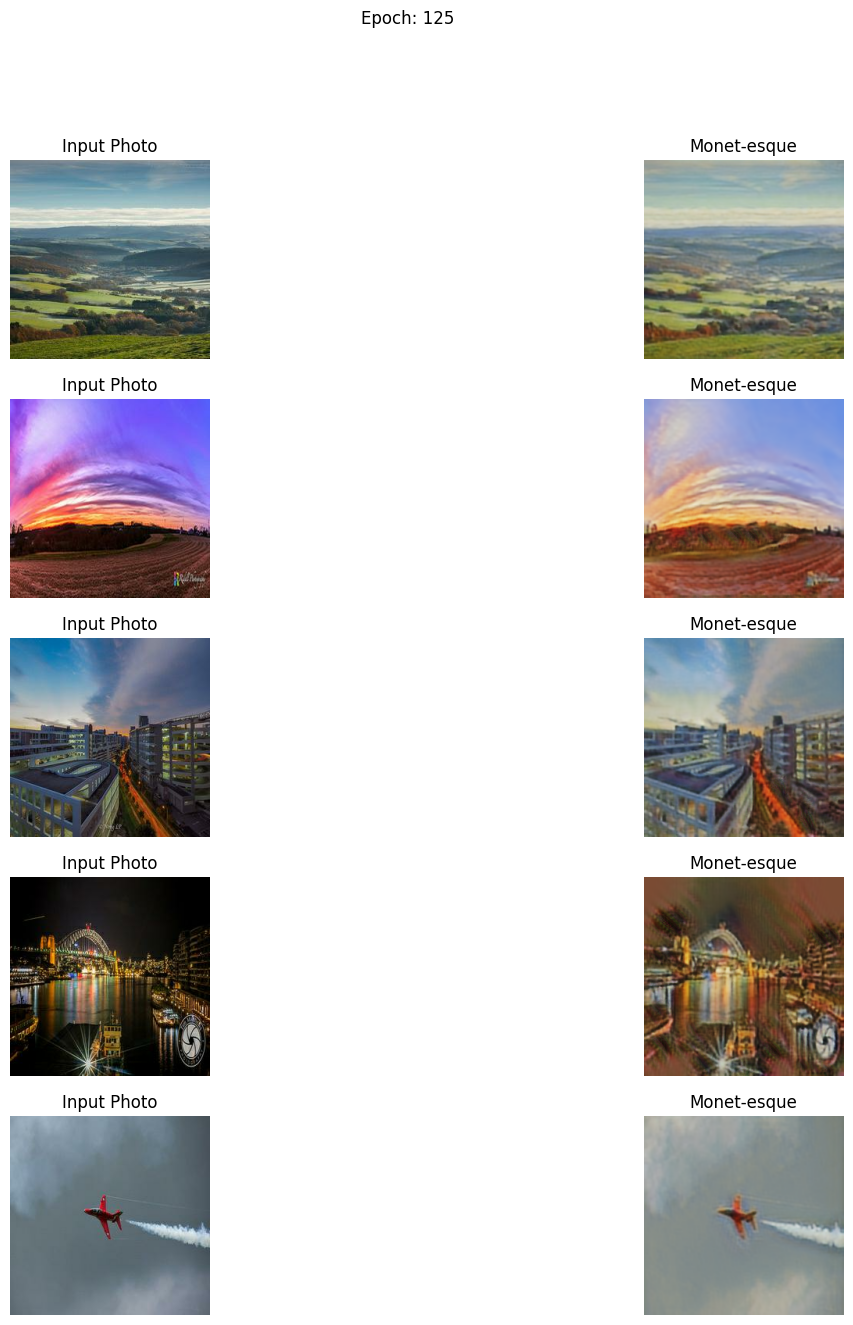

259/259 - 289s - monet_gen_loss: 3.2502 - photo_gen_loss: 2.8950 - monet_disc_loss: 0.7232 - photo_disc_loss: 0.6496 - 289s/epoch - 1s/step
Epoch 127/200
259/259 - 300s - monet_gen_loss: 3.7827 - photo_gen_loss: 3.6705 - monet_disc_loss: 0.4696 - photo_disc_loss: 0.9163 - 300s/epoch - 1s/step
Epoch 128/200
259/259 - 288s - monet_gen_loss: 5.7235 - photo_gen_loss: 4.4291 - monet_disc_loss: 0.5454 - photo_disc_loss: 0.4096 - 288s/epoch - 1s/step
Epoch 129/200
259/259 - 300s - monet_gen_loss: 5.0557 - photo_gen_loss: 4.4988 - monet_disc_loss: 0.1981 - photo_disc_loss: 0.6348 - 300s/epoch - 1s/step
Epoch 130/200
259/259 - 289s - monet_gen_loss: 4.7499 - photo_gen_loss: 5.0018 - monet_disc_loss: 0.2519 - photo_disc_loss: 0.9544 - 289s/epoch - 1s/step
Epoch 131/200
259/259 - 284s - monet_gen_loss: 6.4922 - photo_gen_loss: 6.2902 - monet_disc_loss: 0.3124 - photo_disc_loss: 0.7222 - 284s/epoch - 1s/step
Epoch 132/200
259/259 - 280s - monet_gen_loss: 4.5615 - photo_gen_loss: 4.5033 - monet_dis

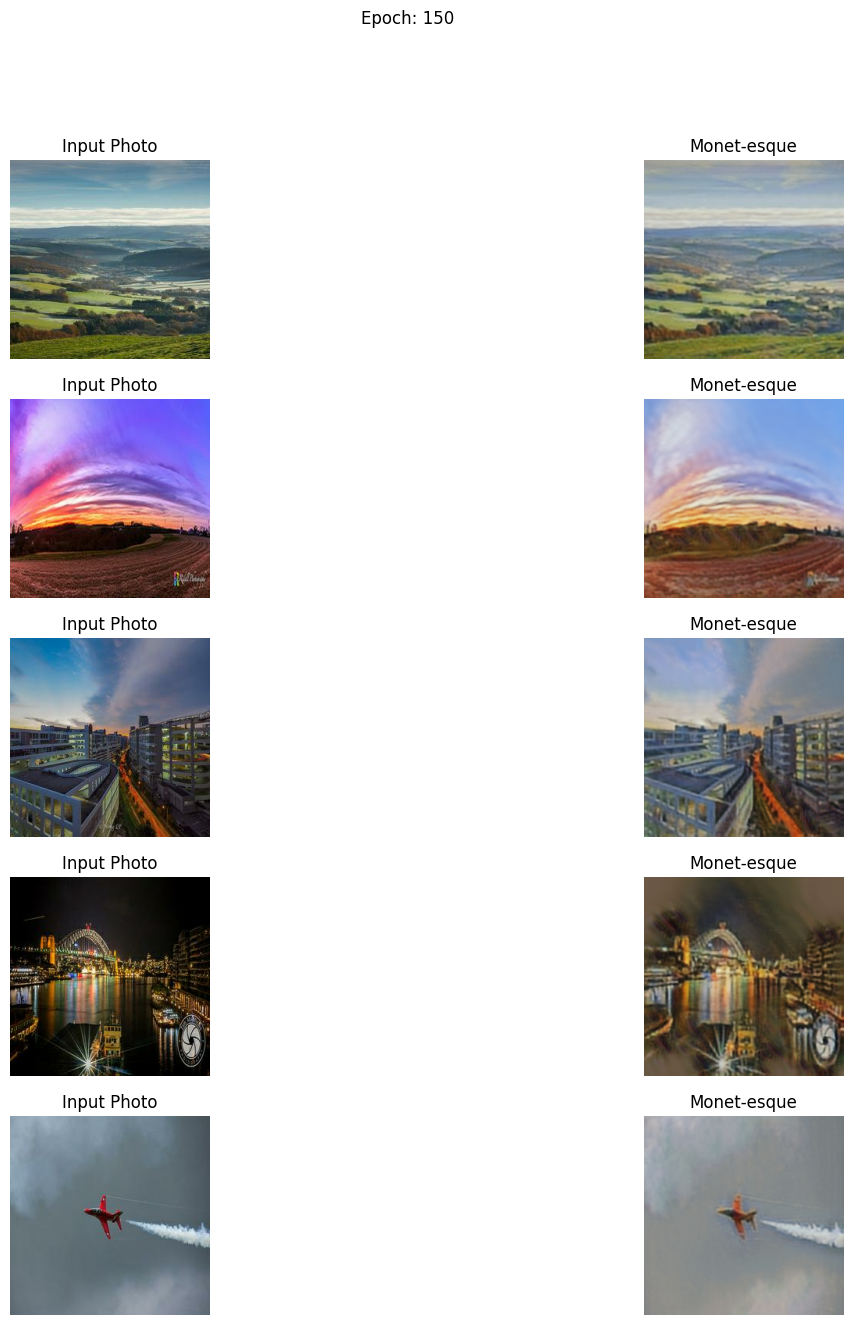

259/259 - 271s - monet_gen_loss: 5.6698 - photo_gen_loss: 4.8451 - monet_disc_loss: 0.3384 - photo_disc_loss: 0.6853 - 271s/epoch - 1s/step
Epoch 152/200
259/259 - 258s - monet_gen_loss: 5.1273 - photo_gen_loss: 3.9936 - monet_disc_loss: 0.3730 - photo_disc_loss: 0.9651 - 258s/epoch - 998ms/step
Epoch 153/200
259/259 - 267s - monet_gen_loss: 5.9490 - photo_gen_loss: 5.2453 - monet_disc_loss: 0.3285 - photo_disc_loss: 0.7701 - 267s/epoch - 1s/step
Epoch 154/200
259/259 - 290s - monet_gen_loss: 5.5225 - photo_gen_loss: 5.5046 - monet_disc_loss: 0.4523 - photo_disc_loss: 0.9054 - 290s/epoch - 1s/step
Epoch 155/200
259/259 - 269s - monet_gen_loss: 6.1034 - photo_gen_loss: 4.2469 - monet_disc_loss: 0.3734 - photo_disc_loss: 0.8184 - 269s/epoch - 1s/step
Epoch 156/200
259/259 - 266s - monet_gen_loss: 6.4935 - photo_gen_loss: 6.4981 - monet_disc_loss: 0.6099 - photo_disc_loss: 0.6740 - 266s/epoch - 1s/step
Epoch 157/200
259/259 - 267s - monet_gen_loss: 5.5275 - photo_gen_loss: 4.3750 - monet_

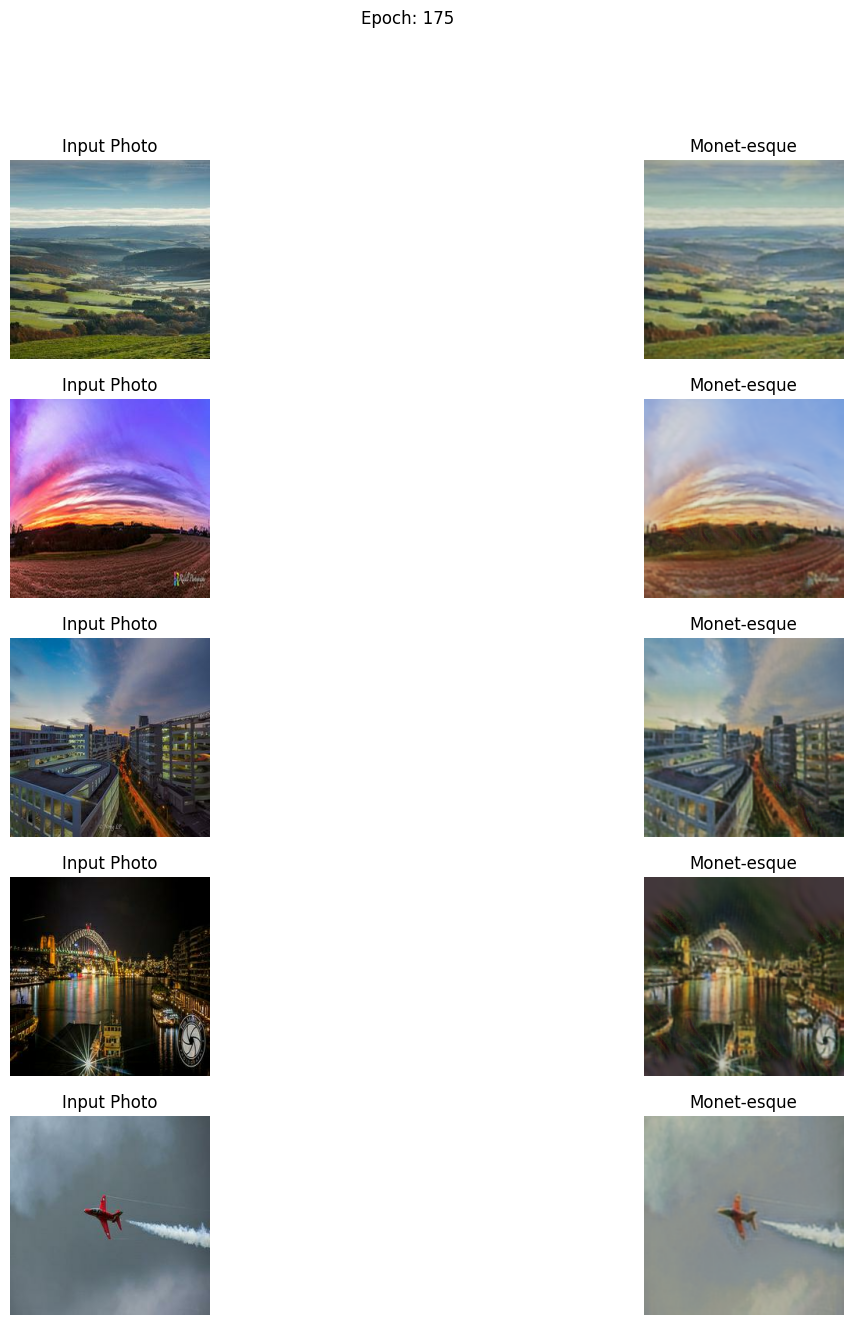

259/259 - 271s - monet_gen_loss: 6.6265 - photo_gen_loss: 6.2537 - monet_disc_loss: 0.1624 - photo_disc_loss: 1.4677 - 271s/epoch - 1s/step
Epoch 177/200
259/259 - 268s - monet_gen_loss: 3.4948 - photo_gen_loss: 3.1674 - monet_disc_loss: 0.3849 - photo_disc_loss: 0.6680 - 268s/epoch - 1s/step
Epoch 178/200
259/259 - 263s - monet_gen_loss: 5.7410 - photo_gen_loss: 4.9629 - monet_disc_loss: 0.3740 - photo_disc_loss: 1.2990 - 263s/epoch - 1s/step
Epoch 179/200
259/259 - 268s - monet_gen_loss: 6.7854 - photo_gen_loss: 6.0403 - monet_disc_loss: 0.3447 - photo_disc_loss: 0.8748 - 268s/epoch - 1s/step
Epoch 180/200
259/259 - 269s - monet_gen_loss: 4.5464 - photo_gen_loss: 3.4619 - monet_disc_loss: 0.1668 - photo_disc_loss: 0.9129 - 269s/epoch - 1s/step
Epoch 181/200
259/259 - 264s - monet_gen_loss: 3.6143 - photo_gen_loss: 3.5956 - monet_disc_loss: 0.4856 - photo_disc_loss: 0.5087 - 264s/epoch - 1s/step
Epoch 182/200
259/259 - 258s - monet_gen_loss: 4.5800 - photo_gen_loss: 4.0315 - monet_dis

In [21]:
model_hist = cycle_gan_model.fit(
    tf.data.Dataset.zip((target_ds, input_ds)),
    epochs=200,
    callbacks=[GANMonitor()],
    verbose = 2
)

### Przebieg trenowania

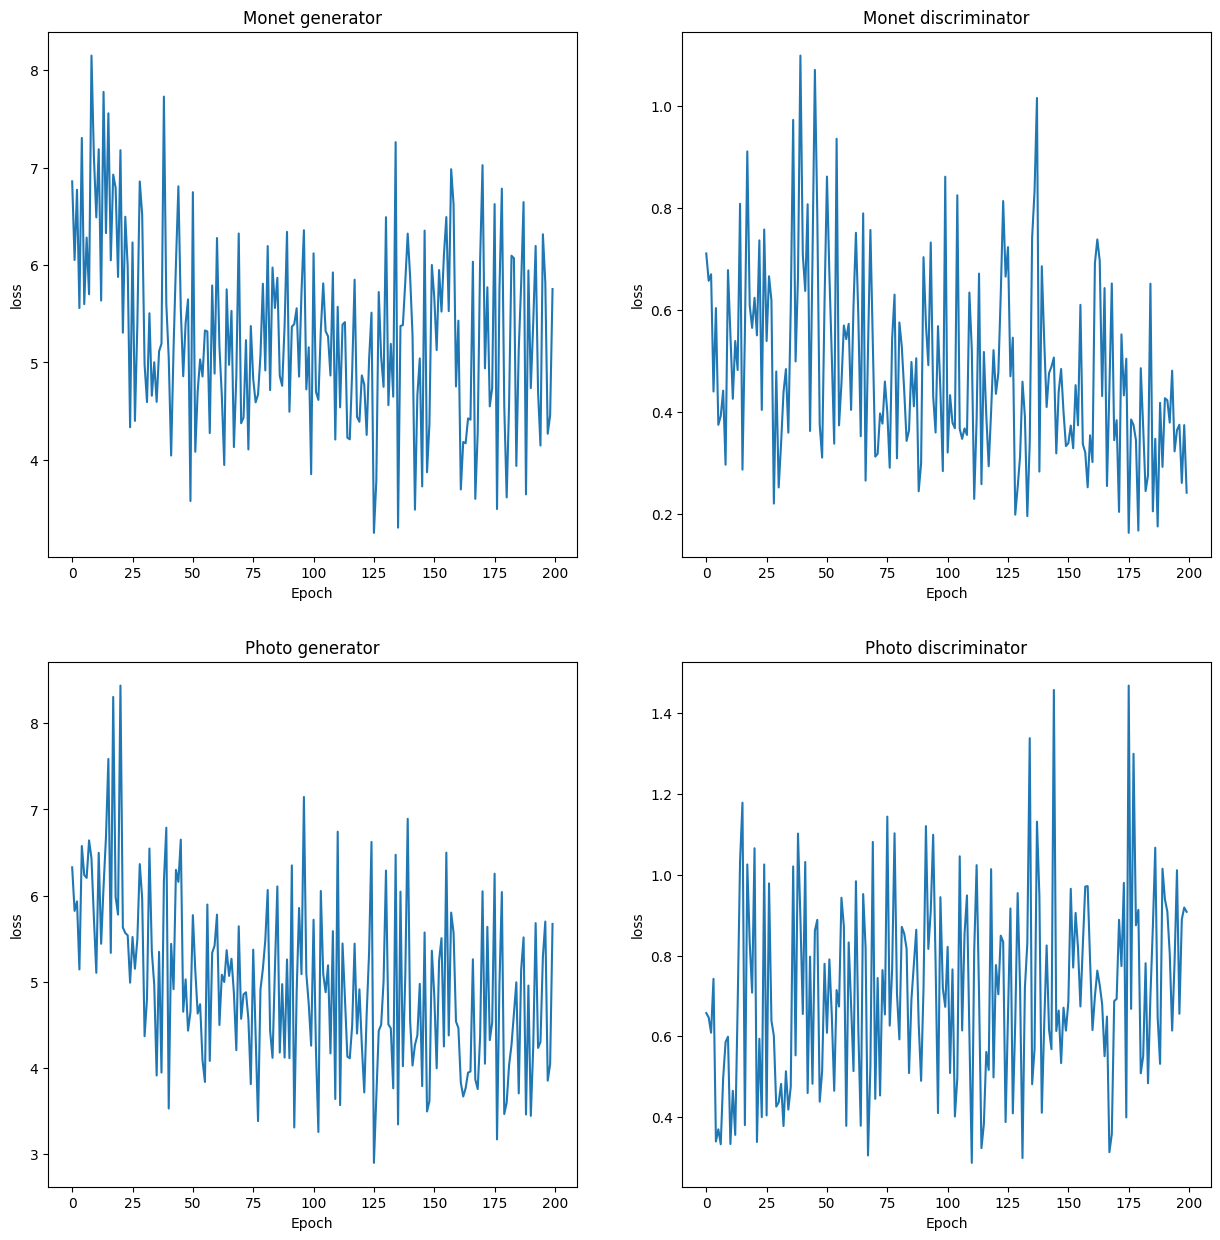

In [22]:
_, ax = plt.subplots(2, 2, figsize=(15, 15))

ax[0, 0].set(xlabel='Epoch', ylabel='loss')
ax[0, 0].plot(model_hist.epoch, np.array(tf.reduce_mean(model_hist.history['monet_gen_loss'], axis=[1, 2, 3])),
         label='loss')
ax[0, 0].set_title("Monet generator")

ax[0, 1].set(xlabel='Epoch', ylabel='loss')
ax[0, 1].plot(model_hist.epoch, np.array(tf.reduce_mean(model_hist.history['monet_disc_loss'], axis=[1, 2, 3])),
         label='loss')
ax[0, 1].set_title("Monet discriminator")

ax[1, 0].set(xlabel='Epoch', ylabel='loss')
ax[1, 0].plot(model_hist.epoch, np.array(tf.reduce_mean(model_hist.history['photo_gen_loss'], axis=[1, 2, 3])),
         label='loss')
ax[1, 0].set_title("Photo generator")

ax[1, 1].set(xlabel='Epoch', ylabel='loss')
ax[1, 1].plot(model_hist.epoch, np.array(tf.reduce_mean(model_hist.history['photo_disc_loss'], axis=[1, 2, 3])),
         label='loss')
ax[1, 1].set_title("Photo discriminator")

plt.show()

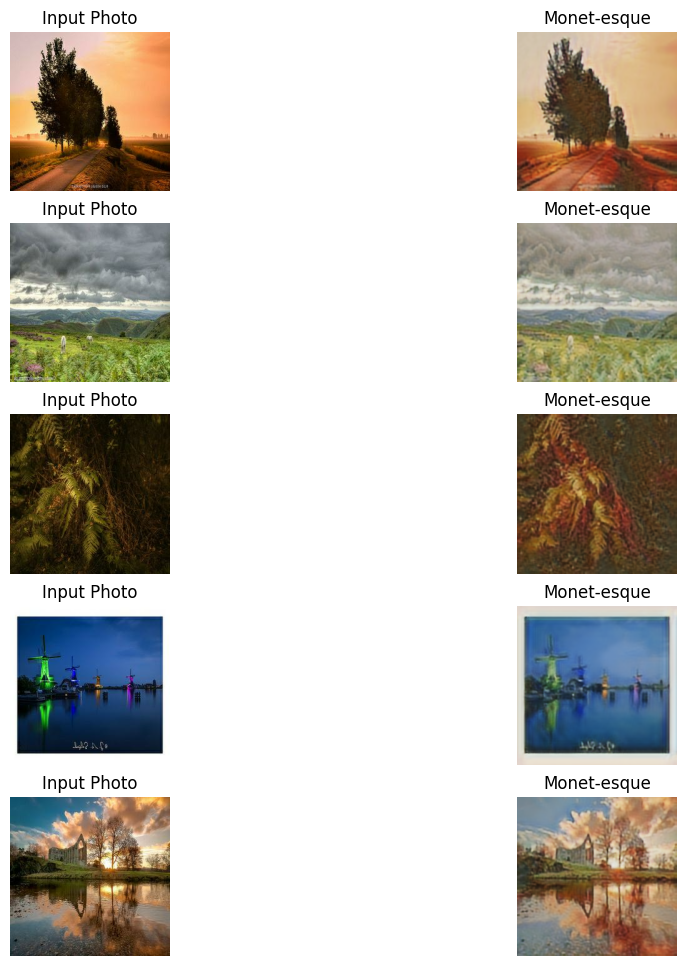

In [25]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(input_ds.take(5)):
    prediction = cycle_gan_model(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

## Zapisanie modelu

In [26]:
cycle_gan_model.compute_output_shape(input_shape=tuple([1] + IMAGE_SIZE))
cycle_gan_model.save("cycleGAN")

INFO:tensorflow:Assets written to: cycleGAN\assets


INFO:tensorflow:Assets written to: cycleGAN\assets
